In [ ]:
import tensorflow as tf
import pandas as pd
import keras
from keras import layers
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
dataframe = sns.load_dataset('penguins')
dataframe["gender"] = dataframe["sex"].map({"Male":1,"Female":0})
dataframe.drop(columns=["species","island","sex"], inplace=True)

In [ ]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    f"Using {len(train_dataframe)} samples for training "
    f"and {len(val_dataframe)} for validation"
)

Using 275 samples for training and 69 for validation


In [ ]:
train_dataframe.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,gender
0,39.1,18.7,181.0,3750.0,1.0
1,39.5,17.4,186.0,3800.0,0.0
4,36.7,19.3,193.0,3450.0,0.0
5,39.3,20.6,190.0,3650.0,1.0
6,38.9,17.8,181.0,3625.0,0.0


In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("gender")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [ ]:

for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'bill_length_mm': <tf.Tensor: shape=(), dtype=float64, numpy=50.8>, 'bill_depth_mm': <tf.Tensor: shape=(), dtype=float64, numpy=19.0>, 'flipper_length_mm': <tf.Tensor: shape=(), dtype=float64, numpy=210.0>, 'body_mass_g': <tf.Tensor: shape=(), dtype=float64, numpy=4100.0>}
Target: tf.Tensor(1.0, shape=(), dtype=float64)


In [ ]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [ ]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = layers.StringLookup if is_string else layers.IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [ ]:

bill_length_mm = keras.Input(shape=(1,), name="bill_length_mm")
bill_depth_mm = keras.Input(shape=(1,), name="bill_depth_mm")
flipper_length_mm = keras.Input(shape=(1,), name="flipper_length_mm")
body_mass_g = keras.Input(shape=(1,), name="body_mass_g")

all_inputs = [
    bill_length_mm,
    bill_depth_mm,
    flipper_length_mm,
    body_mass_g
]

# Numerical features
bill_length_mm_encoded = encode_numerical_feature(bill_length_mm, "bill_length_mm", train_ds)
bill_depth_mm_encoded = encode_numerical_feature(bill_depth_mm, "bill_depth_mm", train_ds)
flipper_length_mm_encoded = encode_numerical_feature(flipper_length_mm, "flipper_length_mm", train_ds)
body_mass_g_encoded = encode_numerical_feature(body_mass_g, "body_mass_g", train_ds)

all_features = layers.concatenate(
    [
        bill_length_mm_encoded,
        bill_depth_mm_encoded,
        flipper_length_mm_encoded,
        body_mass_g_encoded
    ]
)

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

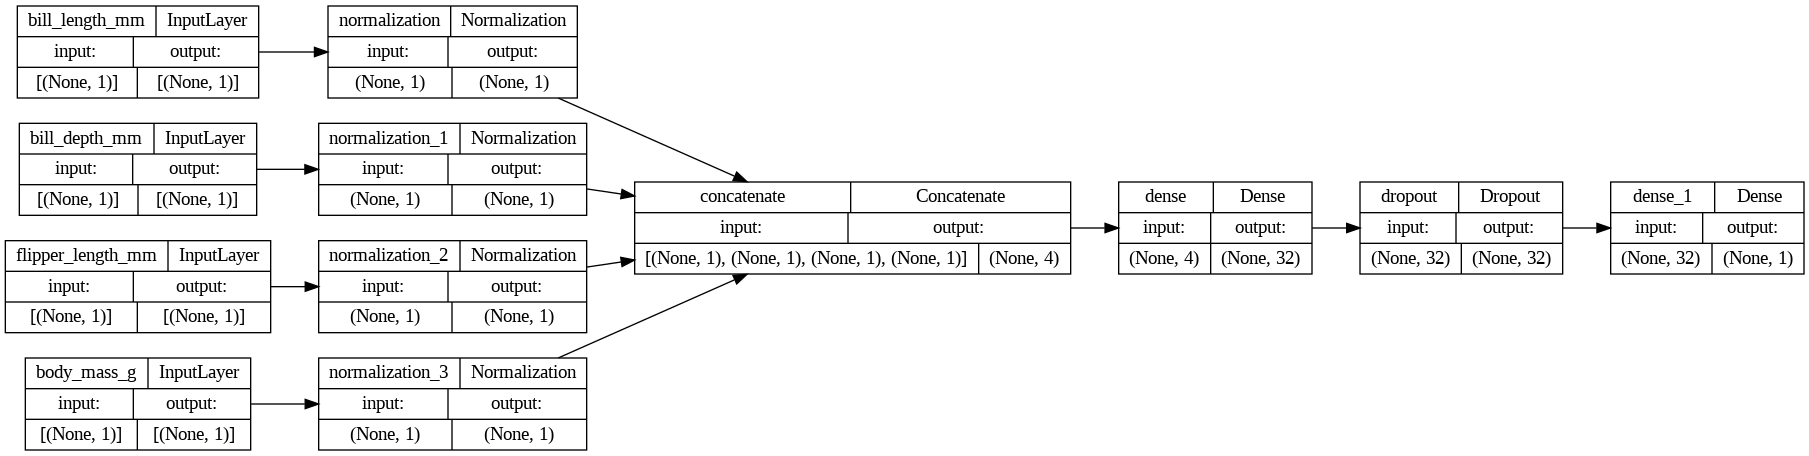

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
9/9 [==============================] - 2s 64ms/step - loss: nan - accuracy: 0.4800 - val_loss: nan - val_accuracy: 0.4783
Epoch 2/5
9/9 [==============================] - 0s 12ms/step - loss: nan - accuracy: 0.4800 - val_loss: nan - val_accuracy: 0.4783
Epoch 3/5
9/9 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.4800 - val_loss: nan - val_accuracy: 0.4783
Epoch 4/5
9/9 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4800 - val_loss: nan - val_accuracy: 0.4783
Epoch 5/5
9/9 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.4800 - val_loss: nan - val_accuracy: 0.4783


In [ ]:
test_loss, test_acc = model.evaluate(train_ds)
percentage = round(test_acc * 100, 2)
print(f'Test accuracy: {percentage}%')
percentage = round(test_loss * 100, 2)
print(f'Test loss: {percentage}%')

9/9 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.4800
Test accuracy: 48.0%
Test loss: nan%
